## Demo of changing face on Misty I via rerobots API

This is free software, released under the Apache License, Version 2.0.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

To learn more about our services, go to https://help.rerobots.net/

Copyright (c) 2018 rerobots, Inc.

In [1]:
API_TOKEN = ''  # GET YOUR TOKEN FROM https://rerobots.net/tokens

In [ ]:
!pip install rerobots
!pip install paramiko

In [3]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
from rerobots.api import APIClient


apic = APIClient(api_token=API_TOKEN)

In [4]:
candidates = apic.get_deployments(types=['fixed_misty1devel'])
instance = apic.request_instance(candidates[0], reserve=False)

In [5]:
## Wait for instance to finish initializing

while True:
    instance_details = apic.get_instance_info(instance['id'])
    if instance_details['status'] == 'READY':
        break
    time.sleep(2)

In [6]:
instance_details

{'deployment': 'f9a4e96f-a8f3-4b25-ae14-5ebdff63f8af',
 'fwd': {'ipv4': '147.75.69.207', 'port': 2210},
 'hostkeys': ['ecdsa-sha2-nistp256 AAAAE2VjZHNhLXNoYTItbmlzdHAyNTYAAAAIbmlzdHAyNTYAAABBBMWqGbR5J5jySPrK3ievwN4OHh4cxVXqOLKaS/HGYYo82gZjM9CFNbH28wVdO20Xlol3zNfA9sWRKR8m98+yVf0= root@rrc'],
 'id': '38c40e61-1268-4527-beba-eac790e4ed46',
 'region': 'us:cali',
 'rootuser': 'scott',
 'starttime': '2018-11-04 03:26:45.645378',
 'status': 'READY',
 'type': 'fixed_misty1devel'}

In [7]:
## Start the "cam" add-on, which supports video streaming

while True:
    payload = apic.status_addon_cam(instance['id'])
    if payload['status'] == 'active':
        break
    elif payload['status'] == 'notfound':
        apic.activate_addon_cam(instance['id'])
    time.sleep(2)

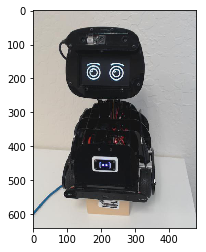

In [8]:
## Display the Misty I Developers' Edition robot as it is now

payload = apic.get_snapshot_cam(instance['id'], format='ndarray')

if not payload['success']:
    time.sleep(1)
    payload = apic.get_snapshot_cam(instance['id'])
    assert payload['success']

plt.imshow(payload['data'])

In [140]:
## Setup ssh

import tempfile
import os
import paramiko


host = instance_details['fwd']['ipv4']
port = instance_details['fwd']['port']
hostkey = instance_details['hostkeys'][0]

fd, keypath = tempfile.mkstemp()
fp = os.fdopen(fd, 'wt')
fp.write(instance['sshkey'])
fp.close()

fd, known_hosts = tempfile.mkstemp()
fp = os.fdopen(fd, 'wt')
sshhost = '[{IPADDR}]:{PORT}'.format(IPADDR=host, PORT=port)
fp.write(sshhost + ' ' + hostkey)
fp.close()

sshclient = paramiko.client.SSHClient()
sshclient.load_system_host_keys(known_hosts)
pkey = paramiko.rsakey.RSAKey.from_private_key_file(keypath)
sshclient.connect(host, port=port, username='root', pkey=pkey, timeout=5)

In [141]:
## Change facial expression
stdin, stdout, stderr = sshclient.exec_command('curl -X POST -d \'{"FileName": "Happy.jpg"}\'  http://10.34.54.1/api/images/change')
time.sleep(1)
stdout.read()

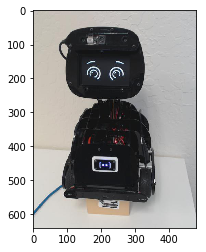

In [142]:
## Display the Misty I Developers' Edition robot as it is now

payload = apic.get_snapshot_cam(instance['id'], format='ndarray')
plt.imshow(payload['data'])

In [9]:
## Tilt head down
stdin, stdout, stderr = sshclient.exec_command('curl -X POST -d \'{"Axis": "pitch", "position": 4, "velocity": 3}\'  http://10.34.54.1/api/beta/head/position')
time.sleep(1)
stdout.read()

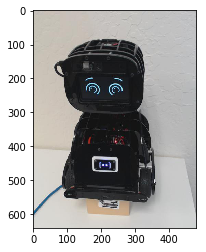

In [144]:
## Display the Misty I Developers' Edition robot as it is now

payload = apic.get_snapshot_cam(instance['id'], format='ndarray')
plt.imshow(payload['data'])

In [ ]:
# Done!

sshclient.close()
apic.terminate_instance(instance['id'])